In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2024 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#  Copyright 2019 - 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)     
#                   Laura Murgatroyd (UKRI-STFC)
#                   Margaret Duff (UKRI-STFC)
#                   Hannah Robarts (UKRI-STFC)

# Demo of optimisation-based reconstruction in CIL

### The case is a 3D parallel-beam synchrotron dataset of a steel wire.

This exercise introduces you to regularised reconstructions. By using prior knowledge of the sample we can choose the most suitable regulariser for the problem. As we introduce different priors we need to use different algorithms to solve the optimisation problem.

Learning objectives are:
- Load a dataset and reconstruct with FBP
- Set-up a least-squares problem to solve using CIL's algorithms, a projection operator and objective function 
- Add regularisation to the least-squares problem and compare the results: Tikhonov, Non-negativity, L1-Norm, Total-Variation
- Solve the optimisation problem with the appropriate algorithm: Gradient Descent, FISTA, PDHG


First we import everything we need:

In [3]:

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation \

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D

# Import from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load, pre-process and reconstruct the data using FBP

Exactly as in the notebook [1_Introduction/03_preprocessing](../1_Introduction/03_preprocessing.ipynb), we load the steel-wire demonstration data provided as part of CIL, carry out some preprocessing and FBP reconstructions for reference:

In [4]:
# Load the example data set
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='astra')

# Set up and run FBP for 90-angle dataset
recon90 = FBP(data90, backend='astra').run(verbose=0)

# Set up and run FBP for 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)
recon15 = FBP(data15, backend='astra').run(verbose=0)

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [6.37, 0.  , 0.  ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [120 135]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (90, 135, 120)
New geometry shape:  (90, 135, 120)
New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [6.37, 0.  , 0.  ]
	

In [5]:
# Define custom parameters for show2D for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
slices = [('horizontal_x',sx),('vertical',sz)]

Show a slice of the 90-degree FBP reconstruction:

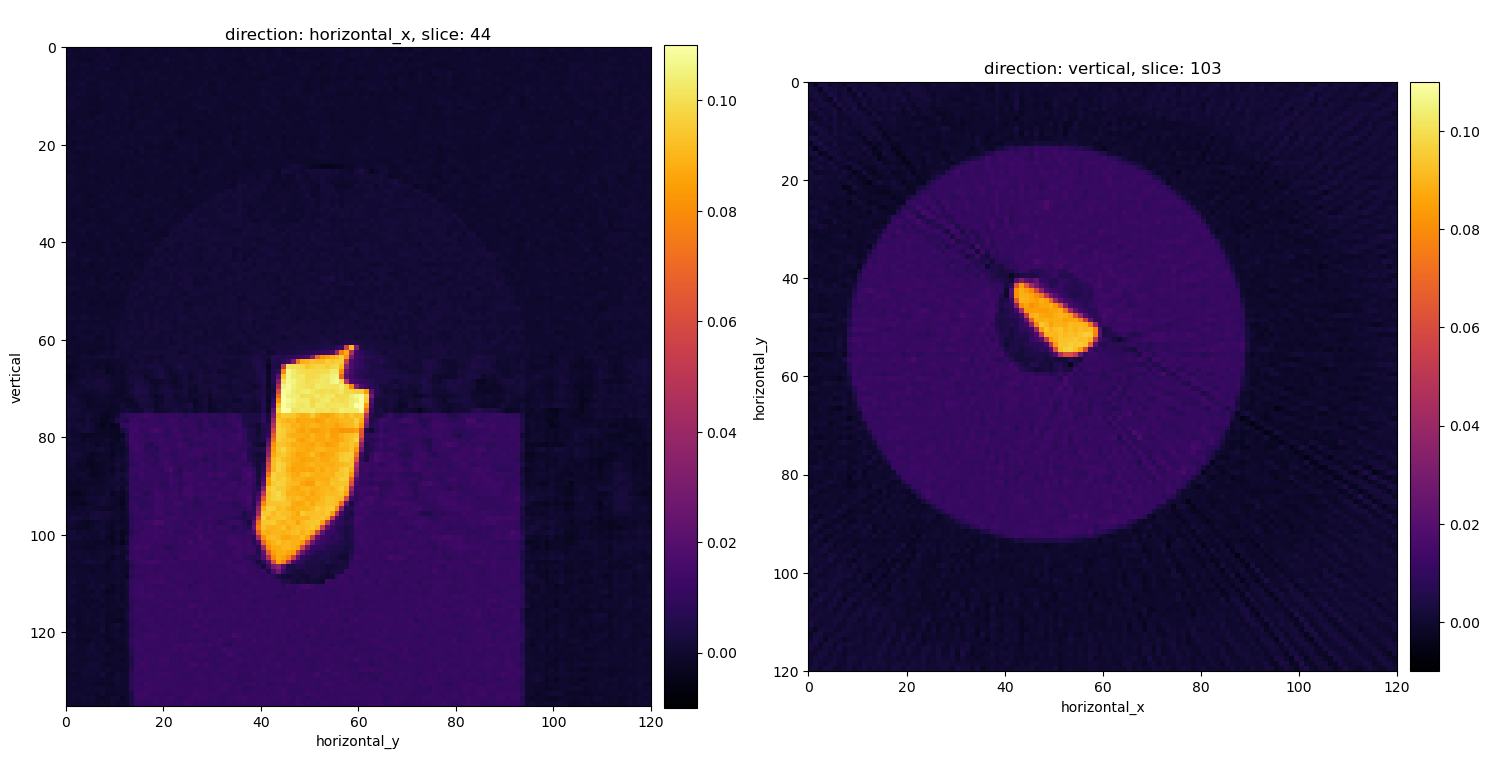

In [6]:
show2D(recon90, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

And the 15-projection FBP reconstruction, which contains severe streak artifacts:

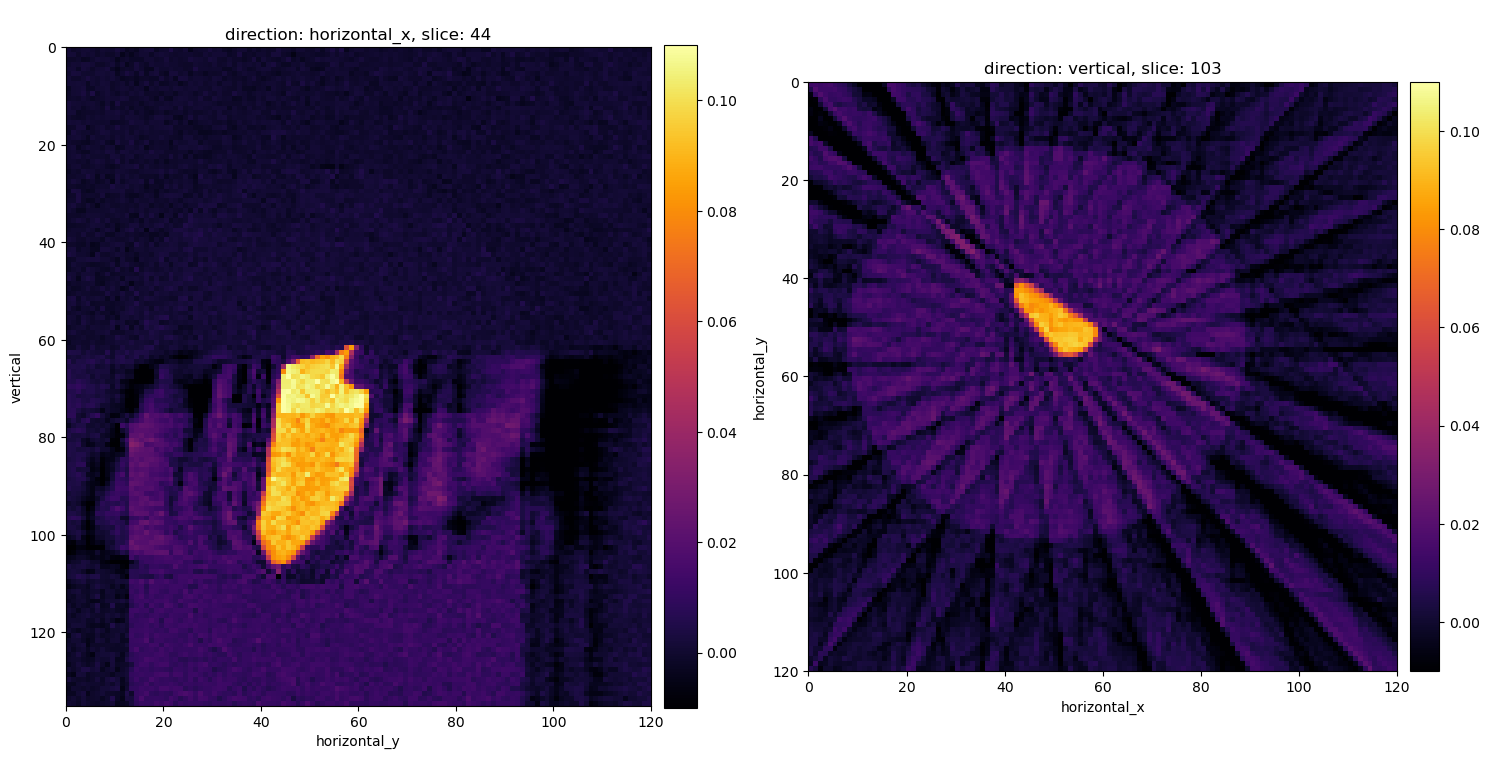

In [7]:
show2D(recon15, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

## Use Gradient Descent to solve a Least Squares problem

Optimisation-based reconstruction is based on a fully discretized model that is conventionally assumed to be linear:
$$Au = b$$
where $A$  is the linear operator known as the system matrix representing forward projection of an image to its sinogram, $b$ is the sinogram data, and $u$ is the unknown image to be reconstructed.

The first thing we are going to need is the LinearOperator representing forward and back-projections. We set up the ProjectionOperator from the ASTRA plugin by passing the 15-projection acquisition geometry, and image geometry:

In [8]:
ag = data15.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")

We choose to work with the 15-projection dataset here and refer to it by `b` for convenience:

In [9]:
b = data15

Unfortunately, as we normally have noise, model errors and other inconsistencies in the data, we cannot expect a solution exists to $Au = b$.  We therefore relax the problem and aim to find a solution that is as close as possible to fitting the data. This is conventionally measured in a least-squares sense in that we solve the least-squares problem
$$ \min_u \|Au - b \|_2^2 $$
where
$$\|y \|_2^2 = \sum_i y_i^2.$$
The function that is to be minimized is called the objective function.

The reconstruction is the image $u$ that is the solution to the optimisation problem, i.e., that results in the lowest possible value of the objective function, in this case of the (squared) residual norm $\|Au - b \|_2^2$. In order to find the solution we use an iterative optimisation algorithm. Many exist, perhaps the most basic one is the gradient descent method, which is available in CIL as the [`GD`](https://tomographicimaging.github.io/CIL/nightly/optimisation.html#gd) algorithm. To set it up we need to specify the objective function in terms of a CIL Function. For [`LeastSquares`](https://tomographicimaging.github.io/CIL/nightly/optimisation.html#least-squares) this is simply:

In [10]:
f1 = LeastSquares(A, b)

In iterative algorithms we must provide an initial point from which to start, here we choose the zero image. 

In [11]:
x0 = ig.allocate(0.0)

`f1` is a CIL Function and CIL Functions can be evaluated for particular input images, for example we can evaluate it (which is the starting objective value of the optimisation problem)  for `x0`:

In [12]:
f1(x0)

81174.6171875

CIL Functions provide a number of methods that are used by optimisation algorithms, most notably, if a function is smooth (continuously differentiable), then a CIL Function provides the `gradient` method using which the gradient of the function can be evaluated at a particular input image. For example we can evaluate the gradient at `x0` and since it contains an element for each voxel, we can display it as an image:

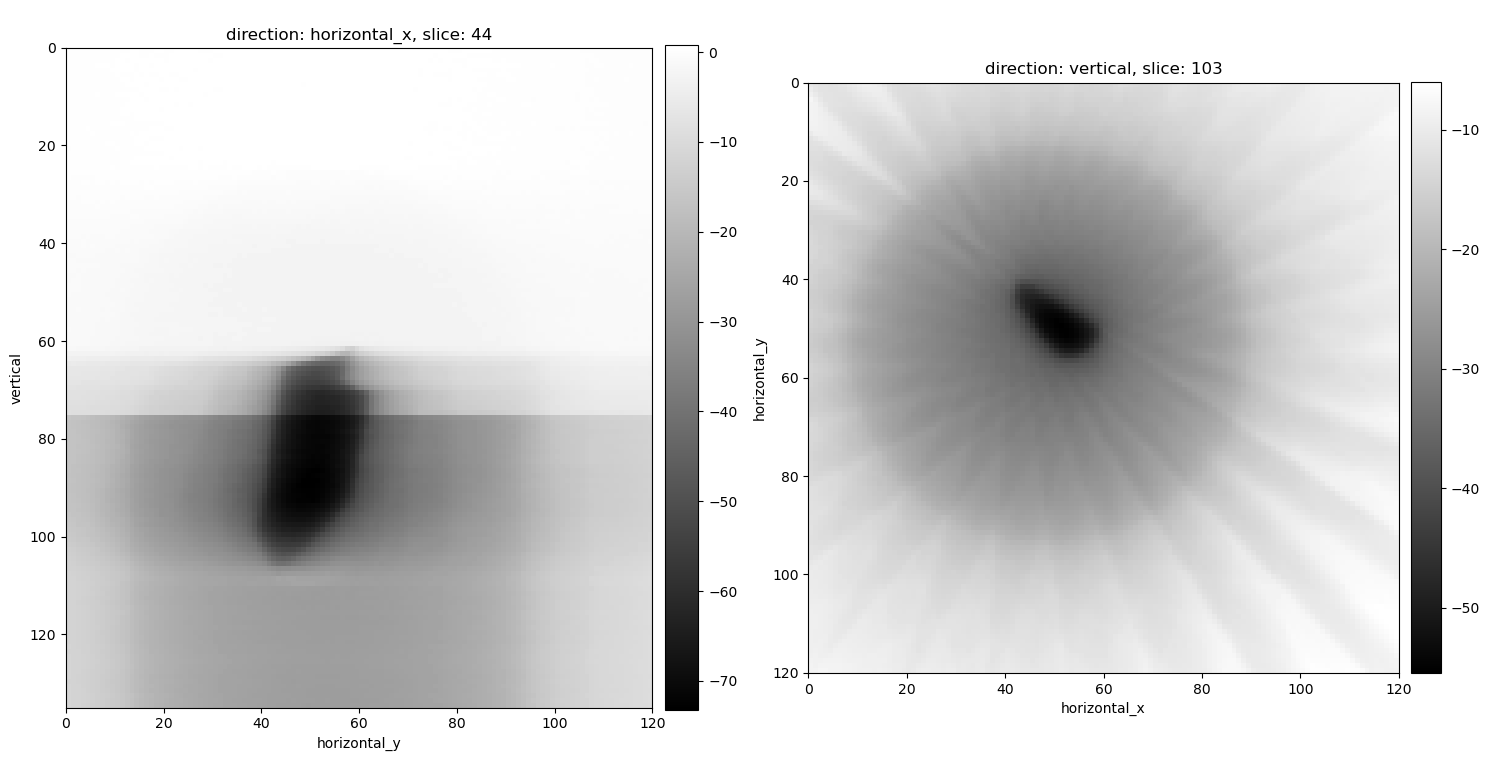

In [13]:
show2D(f1.gradient(x0),slice_list=slices,origin='upper-left')

To set up the gradient descent algorithm, we specify:
 - `initial` - the initial point 
 - `f` - the objective function
 - `step_size` - whether to use a fixed step size or a back-tracking line search (None) or  a function that takes the initialised algorithm and returns a step size which can vary e.g. on objective value or iteration number. For more information see: https://tomographicimaging.github.io/CIL/nightly/optimisation/#step-size-methods. 
 - `update_objective_interval` - how often to evaluate the objective function value
 - `preconditioner` (optional) a functional that takes a calculated gradient and the initialised algorithm and *preconditions* the gradient, e.g. multiplies it by a matrix to provide a (hopefully) more effective descent direction. For more information see, https://tomographicimaging.github.io/CIL/nightly/optimisation/#preconditioners. 
 
 

In [14]:
myGD_LS = GD(initial=x0, 
             f=f1, 
             step_size=None, 
             update_objective_interval=10)

Once the algorithm is set up, we can run it for a specified number of iterations and here using `verbose=1` to print out progress information:

In [15]:
myGD_LS.run(300, verbose=1)

  0%|          | 0/300 [00:00<?, ?it/s]

Once done, the latest image/solution in the algorithm can be shown as an image:

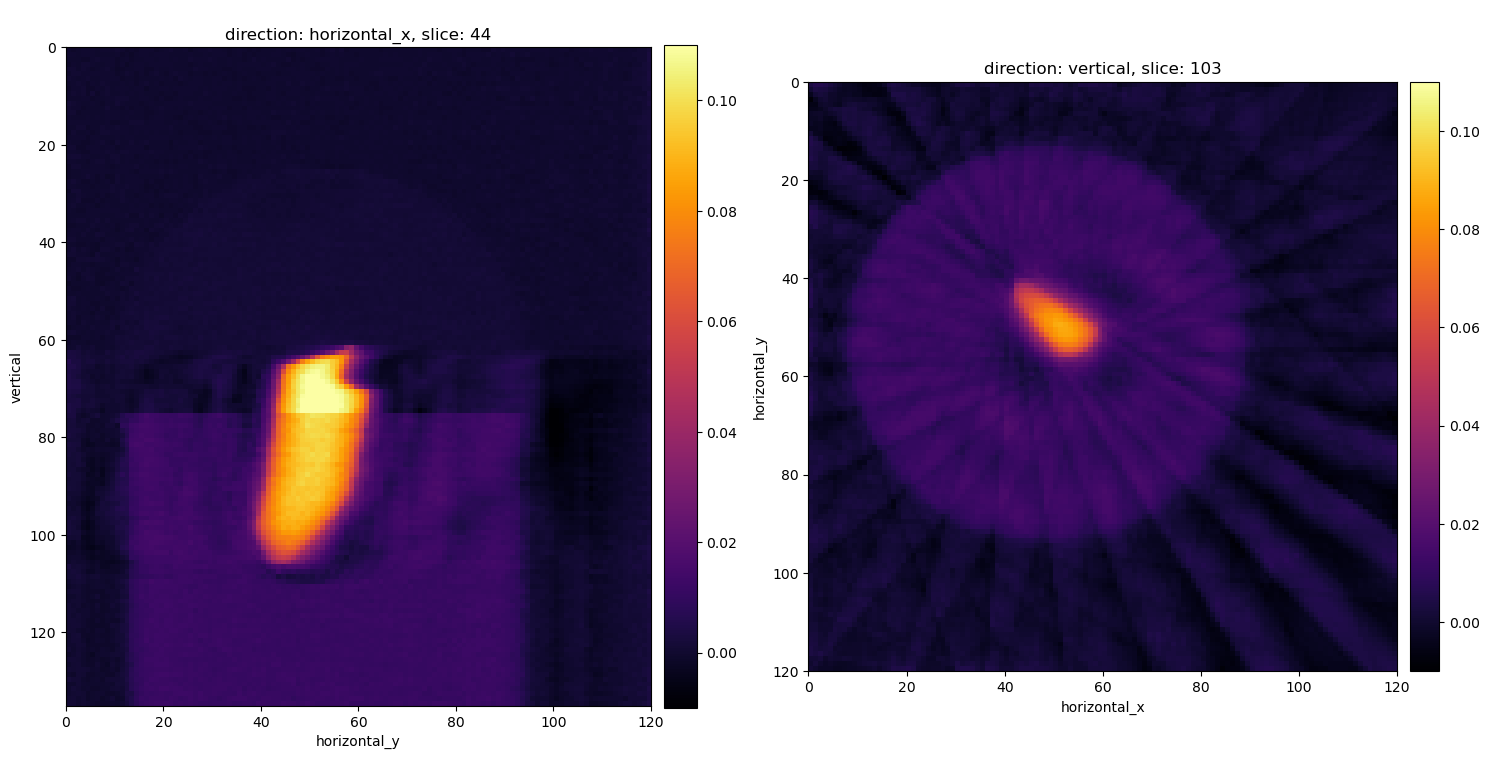

In [16]:
show2D(myGD_LS.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

### Add an L2-Norm penalty to the solution

This was a basic least-squares example. We can specify more involved optimisation problems by combining multiple CIL Functions through addition, scalar multiplication as well as composition with CIL operators. For example, as an alternative to using CGLS to solve the Tikhonov problem with gradient operator D, i.e.,  
$$\min_u \|Au-b\|_2^2 + \alpha^2\|Du\|_2^2$$

Tikhonov regularisation is more explicit in that a regularisation term is added to the least squares fitting term, specifically a squared 2-norm. This is covered in detail by the next notebook [02_tikhonov_block_framework.ipynb](02_tikhonov_block_framework.ipynb)

We can set this objective function up step by step. First, we set again the least-squares data fitting term as before:

In [17]:
f1 = LeastSquares(A, b)

Next we specify the operator `D` in the regularisation term and the value of the regularisation parameter `alpha`:

In [18]:
D = GradientOperator(ig)
alpha = 10.0

We can construct the regularisation term by composing the squared L2-norm with the operator D as:

In [19]:
f2 = OperatorCompositionFunction(L2NormSquared(),D)

Finally we form the full optimisation problem from the components defined:

In [20]:
f = f1 + (alpha**2)*f2

As before we can set up a gradient descent algorithm to solve this problem. This time, we determine a fixed step size, the reciprical of the Lipschitz constant of `f`. 

In [21]:
myGD_tikh = GD(initial=x0, 
               f=f, 
               step_size=1/f.L, 
               update_objective_interval = 10)

In [22]:
myGD_tikh.run(200, verbose=1)

  0%|          | 0/200 [00:00<?, ?it/s]

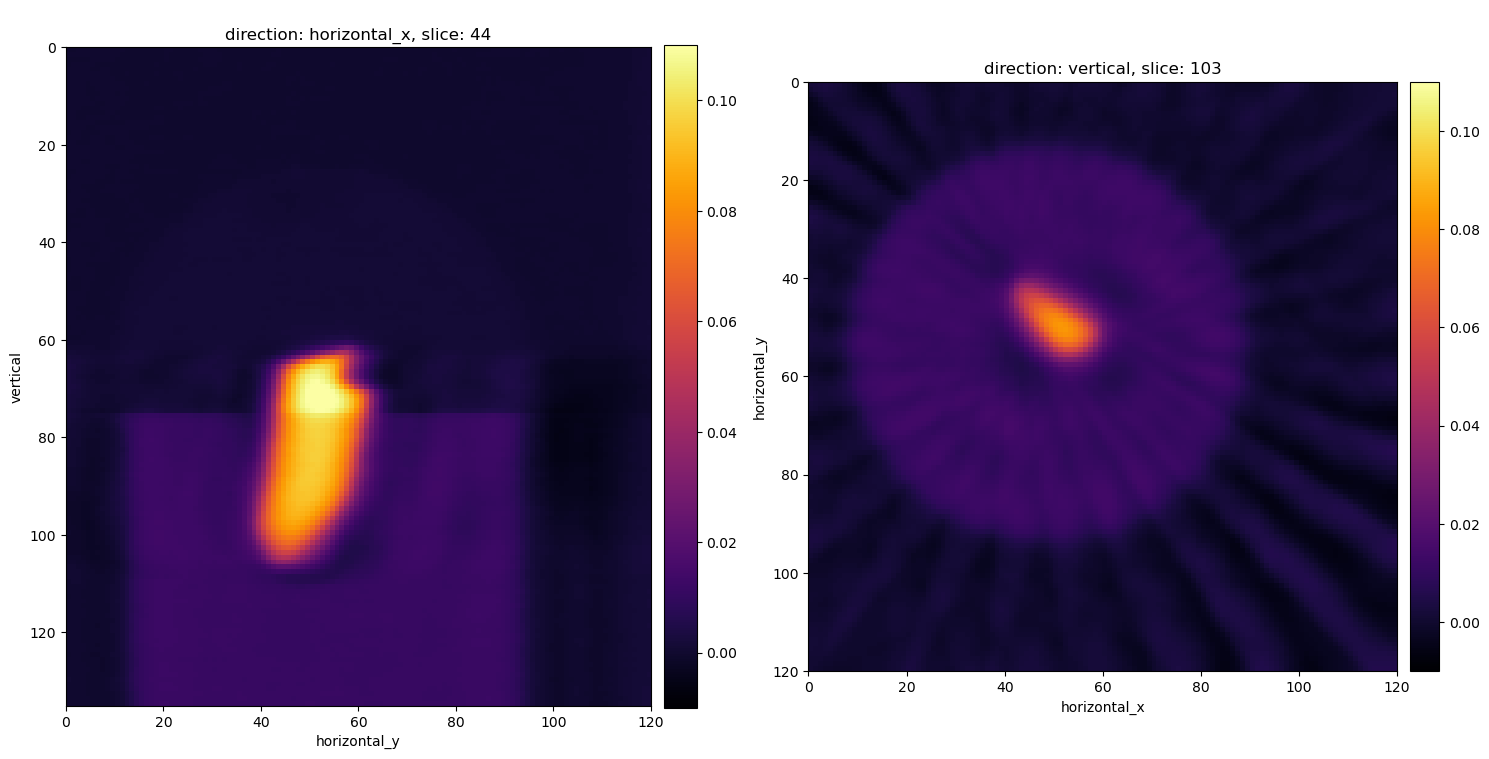

In [23]:
show2D(myGD_tikh.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

In the next notebook we solve the Tikhonov problem using CGLS. As an exercise  you can compare the result and performance of the two algorithms.

## Use FISTA to solve a Least Squares problem with a non-negativity constraint

Many useful reconstruction methods involve minimisation of functions that are NOT smooth and in those cases we need dedicated optimisation algorithms for non-smooth problems. In this notebook we consider optimisation problems that can be written in the form
$$\min_u f(u) + g(u)  $$
where $f$ is a smooth function as before, but $g$ may now be non-smooth. $g$ further needs to be "simple", in a certain sense, namely it should have a proximal mapping that is easy to evaluate. Proximal mapping can be thought of a generalisation of the gradient for a non-smooth function.

For this problem class the algorithm FISTA (Fast iterative shrinkage thresholding algorithm) can be employed. It is also known as the accelerated proximal gradient method.

We consider a couple of examples for different functions $g$. First we consider again least-squares but with a non-negativity constraint on all pixels. This problem can be written 
$$\min_u \|Au-b\|_2^2 + I_{C}(u) $$
where $I_{C}(u)$ is a special convex function known as an indicator function, which takes on the value 0 in its convex domain C (which we here take to be the set of images with only nonnegative pixel values), and the (extended) value of $\infty$ outside its domain. This can be specified in CIL using an `IndicatorBox` function:

In [24]:
F = LeastSquares(A, b)
G = IndicatorBox(lower=0.0)

A FISTA algorithm instance can be set up similarly to the GD algorithm but specifying the $f$ and $g$ functions separately:

In [25]:
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  update_objective_interval = 10)

We run it and display the resulting solution:

In [26]:
myFISTANN.run(300, verbose=1)

  0%|          | 0/300 [00:00<?, ?it/s]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb3

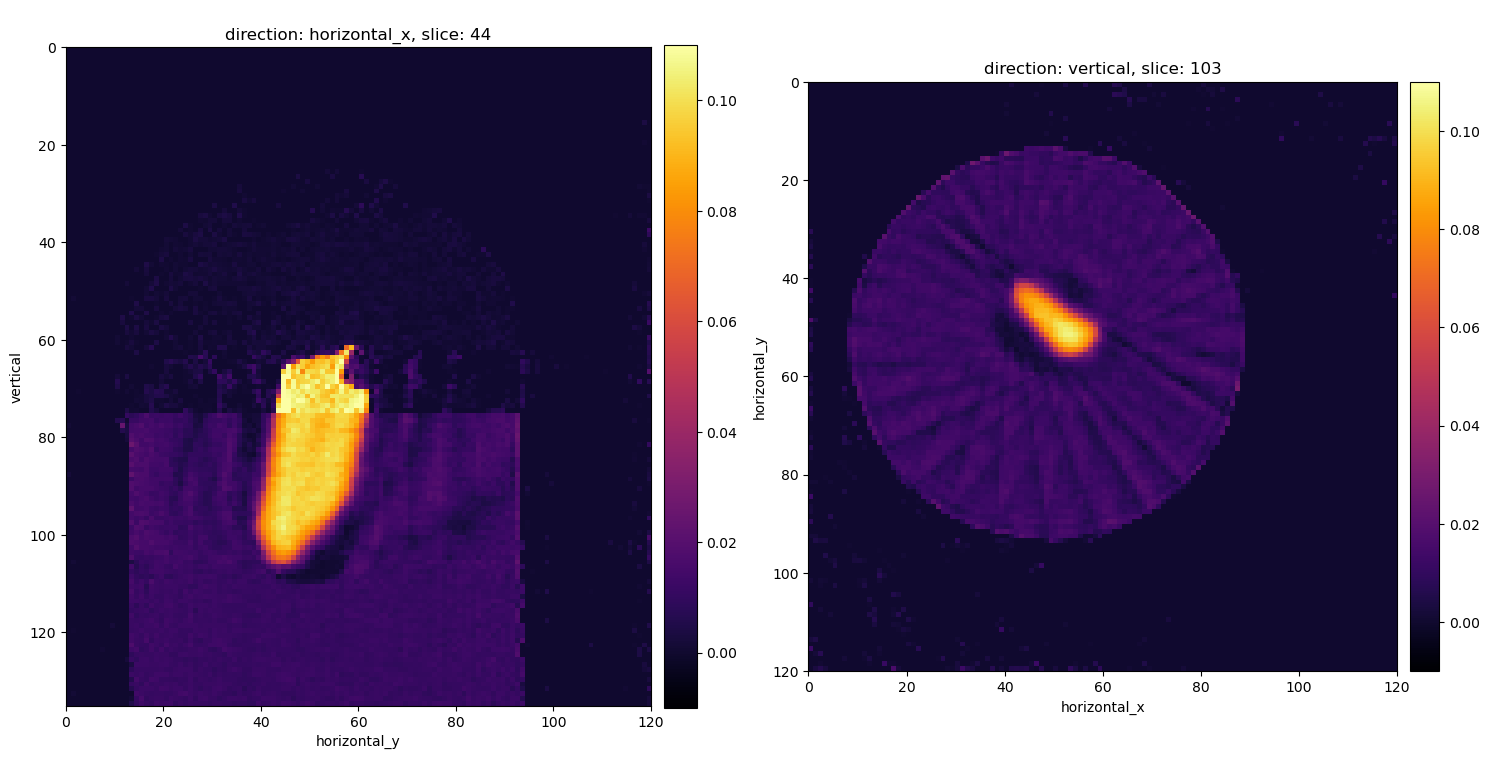

In [27]:
show2D(myFISTANN.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

We see that the non-negativity constraint, as expected, prevents any negative values. Furthermore, this has a positive effect of removing some of the streak artifacts in the background.

## Use FISTA to solve a Least Squares problem with an L1-norm penalty

Another possibility is sparsity regularisation which we can achieve by choosing $g$ as the L1-norm multiplied by a regularisation parameter $\alpha$ to balance the strength of fitting to the data and enforcing regularisation:
$$g(u) = \alpha\|u\|_1 = \alpha\sum_u |u_i| $$

**Exercise 1**

We will set up the fista algorithm as we did before. But replace the `IndicatorBox()` with `alpha * L1Norm()`

**Uncomment and run the cells to see the solution:**

In [28]:
alpha = 30
G = alpha*L1Norm()
F = LeastSquares(A, b)

myFISTAL1 = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  update_objective_interval=10)

Now run 300 iterations of `myFISTAL1`

In [29]:
myFISTAL1.run(300,verbose=1)

  0%|          | 0/300 [00:00<?, ?it/s]

We show the solution of L1 regularised least-squares produced by FISTA:

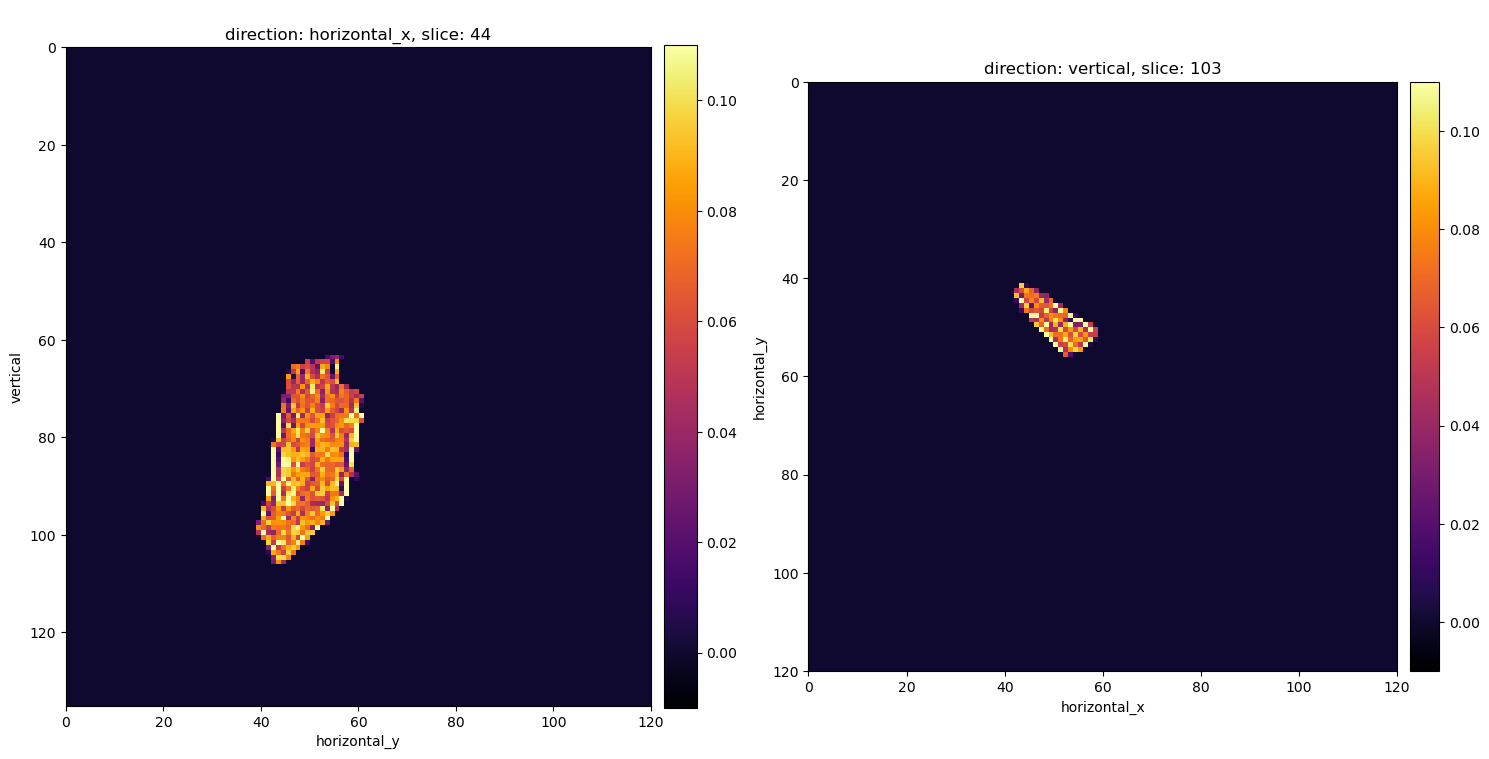

In [30]:
show2D(myFISTAL1.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

Here, all small values of the background, and the lowest-density parts of the sample, have been forced to be zero by the sparsity regularisation term, keeping only the pixel values of the largest magnitude. Sparsity regularisation does not directly enforce smoothing, which is seen in the image by neighbouring pixel values being rather different in the part of the image that is not zero.

## Use FISTA to solve a Least Squares problem with Total Variation regularisation

Sometimes a better option is to enforce sparsity of the image gradient. This is known as Total Variation (TV) regularisation and tends to enforce piecewise constant areas separated by sharp edges. Recall that for example Tikhonov regularisation may reduce noise but tends to blur edges, so TV may have an advantage if the image to be reconstructed is known to consist of relatively homogeneous areas separated by sharp edges. In CIL, TV is available as the `TotalVariation` function and from the CCPi regularisation toolkit as `FGP_TV` which can be run on the `GPU`. We can set up and solve the TV-regularised problem in the same way as before:

**Exercise 2**

Change the strength of the regularisation and see what effect high and very low values of alpha have on the reconstruction. Try to find a value that smooths the streaks but preserves the features.

In [31]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.02

In [32]:
GTV = alpha*FGP_TV(device='gpu', nonnegativity=True) 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  update_objective_interval = 10)

Show the slices of the TV reconstruction by FISTA:

Note that the proximal mapping of Total Variation is not simple but needs to be evaluated numerically, but this is handled by the `TotalVariation` and `FGP_TV` functions, however it does take a while to run which is why we use the `GPU` implementation on real data (approximately 3 minutes):

In [33]:
myFISTATV.run(200,verbose=1)

  0%|          | 0/200 [00:00<?, ?it/s]

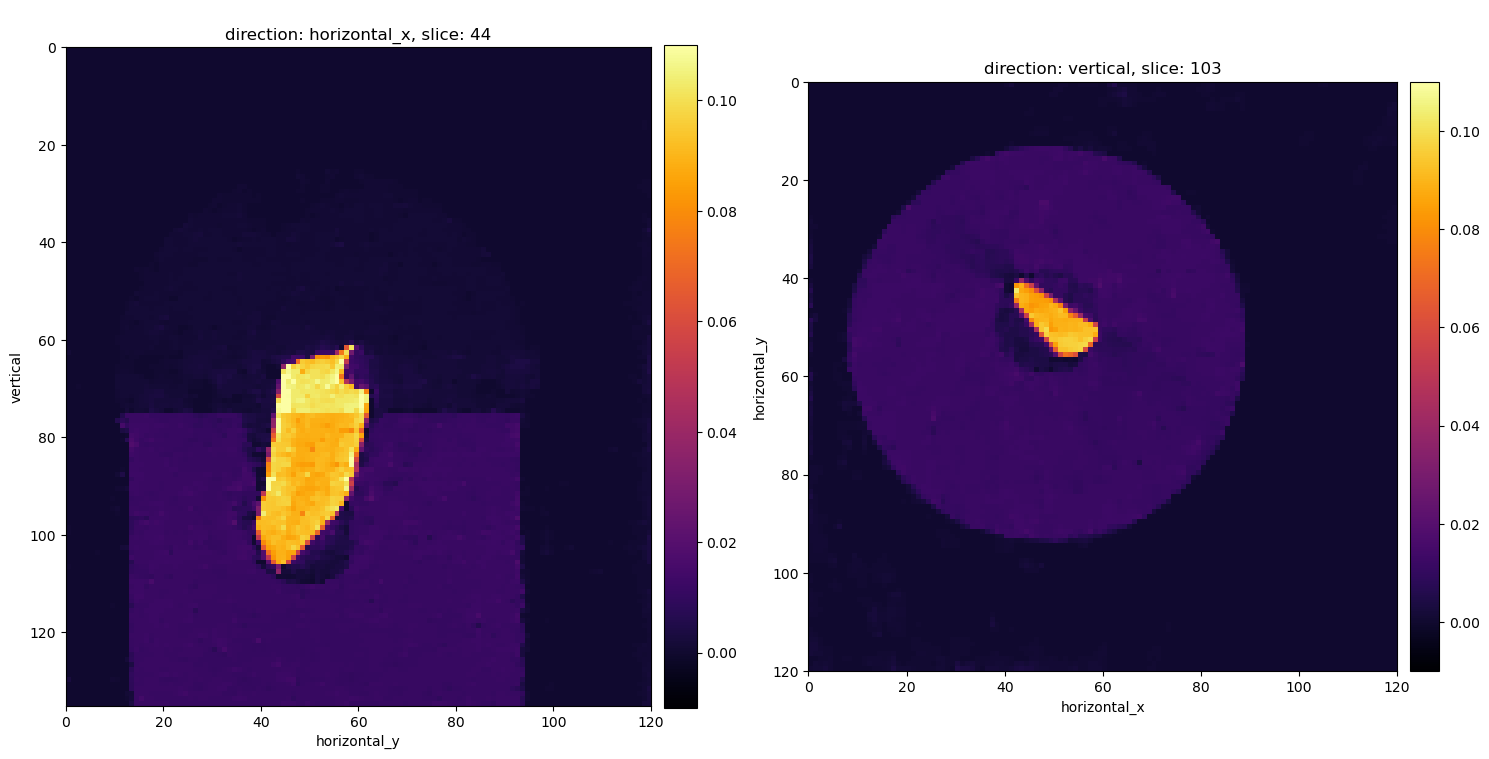

In [34]:
show2D(myFISTATV.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

We can see that TV-regularisation successfully compensates for the streak artifacts caused by few projections, suppresses noise and preserves sharp edges in the reconstruction.

In [35]:
if math.isclose(myFISTATV.g.alpha, 0.02, abs_tol=0.006) and myFISTATV.iteration > 199:
    print("Good job, carry on!")
else:
    raise ValueError("Try again: run 200 iterations with alpha of 0.02")


Good job, carry on!


## Use PDHG to solve a Least Squares problem with Total Variation regularisation

An even more flexible algorithm for non-smooth problems is the Primal Dual Hybrid Gradient (PDHG) algorithm, which also goes under other names such as the Chambolle-Pock algorithm. In PDHG we can split complicated functionals into simpler parts for which the proximal mapping can be evaluated. PDHG will be covered in more detail in a separate notebook [03_PDHG.ipynb](03_PDHG.ipynb), here it is demonstrated how to set up the same TV-regularised problem we just solved with FISTA. Note how `BlockFunctions` and `BlockOperators` are used to specify multiple terms/operators:

In [36]:
alpha = 0.02
F = BlockFunction(L2NormSquared(b=b), 
                  alpha*MixedL21Norm())
K = BlockOperator(A, 
                  D)
G = IndicatorBox(lower=0.0)
myPDHG = PDHG(f=F, 
              g=G, 
              operator=K, 
              update_objective_interval = 10,
              check_convergence = False)

Run the algorithm for a specified number of iterations with increased verbosity/amount of printing to screen.

Here we run for 500 iterations.

In [37]:
myPDHG.run(500,verbose=2)

  0%|          | 0/500 [00:00<?, ?it/s]

Show the TV-regularised solution obtained by the PDHG Algorithm:

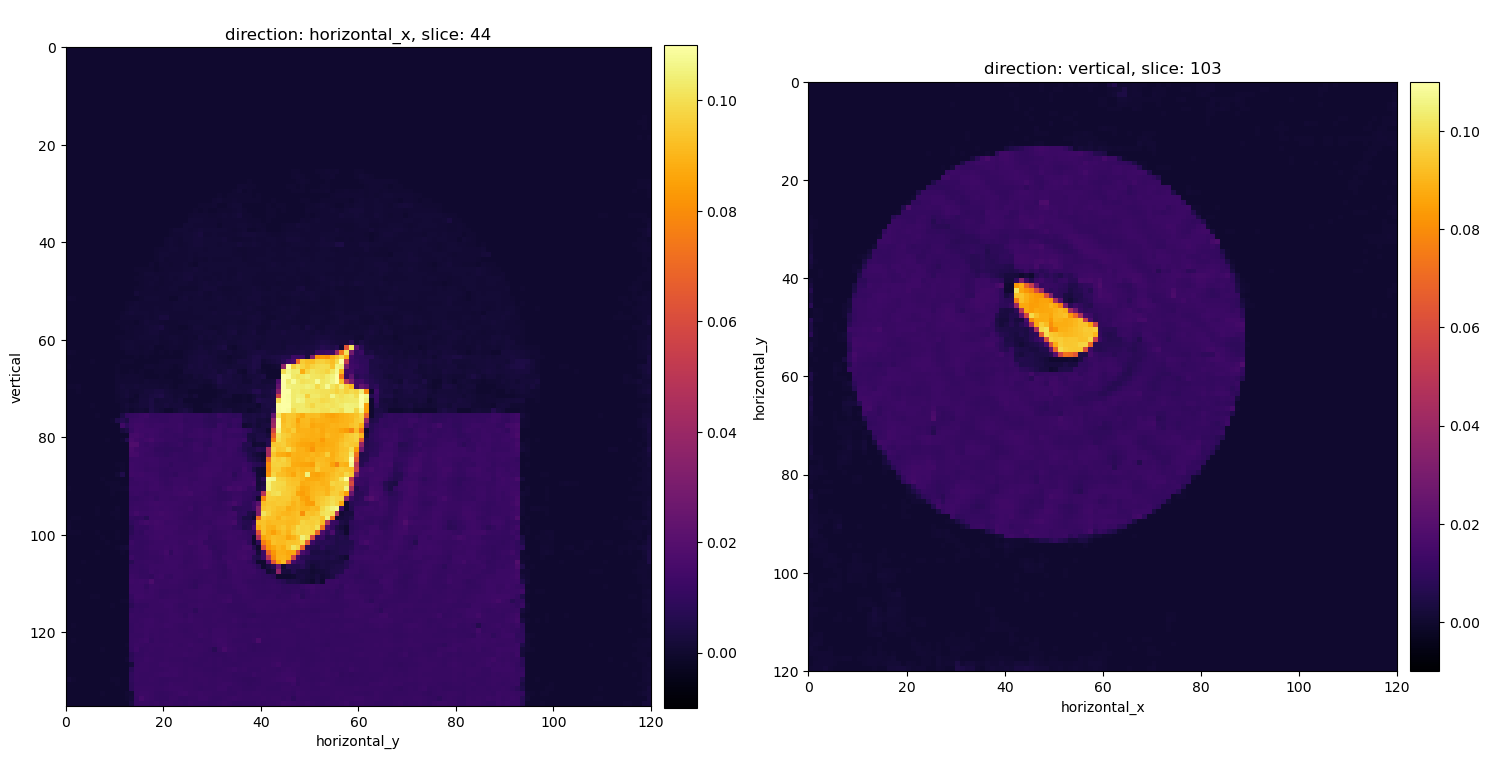

In [38]:
show2D(myPDHG.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

## Convergence of the algorithms

CIL Algorithms can record history of objective values (primal and dual for PDHG) for monitoring convergence:

Text(0, 0.5, 'Objective value')

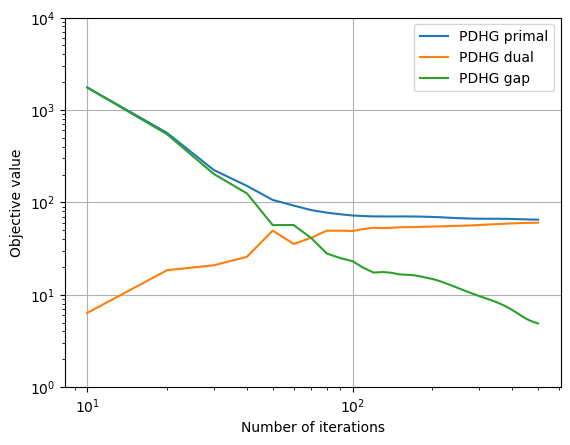

In [39]:
plt.figure()
plt.loglog(myPDHG.iterations[1:], myPDHG.objective[1:])
plt.loglog(myPDHG.iterations[1:], myPDHG.dual_objective[1:])
plt.loglog(myPDHG.iterations[1:], myPDHG.primal_dual_gap[1:])
plt.ylim((1e0,1e4))
plt.legend(['PDHG primal','PDHG dual','PDHG gap'])
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')

PDHG supplies the primal objective, the dual objective, and the primal-dual gap (difference of primal of dual objectives) which helps for monitoring convergence. We see that the primal-dual gap is tending towards zero as the algorithm approaches the solution. 

To have a well-converged primal-dual gap, we want to run for more iterations, in this case, another 500 iterations. In practice, we often see a visually converged image in fewer iterations.  

In [40]:
myPDHG.run(500,verbose=2)

 50%|#####     | 501/1000 [00:00<?, ?it/s]

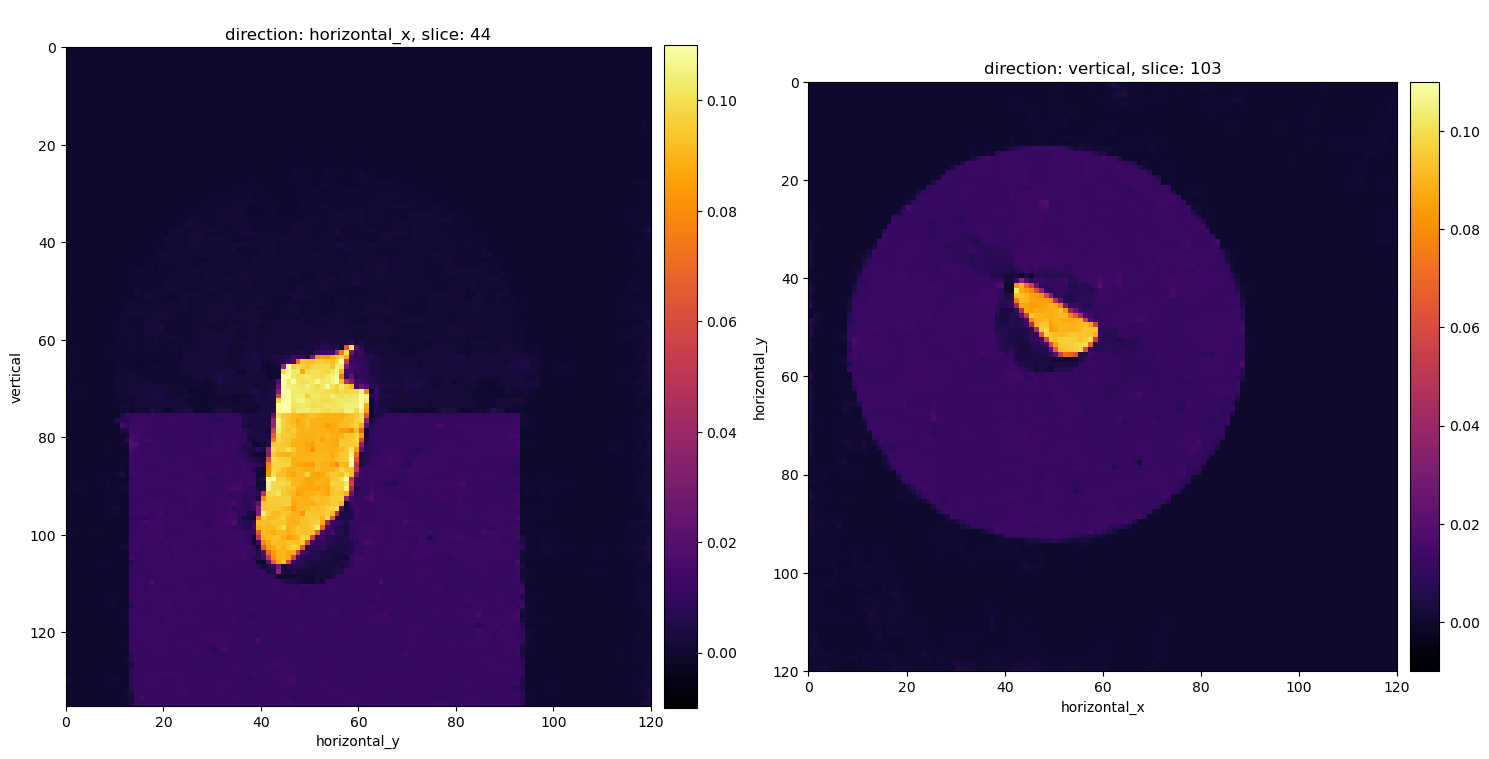

In [41]:
show2D(myPDHG.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

We see the resulting image matches the FISTA solution, and plotting the conververgence we observe that the two algorithms achieve approximately the same (primal) objective value.

Text(0, 0.5, 'Objective value')

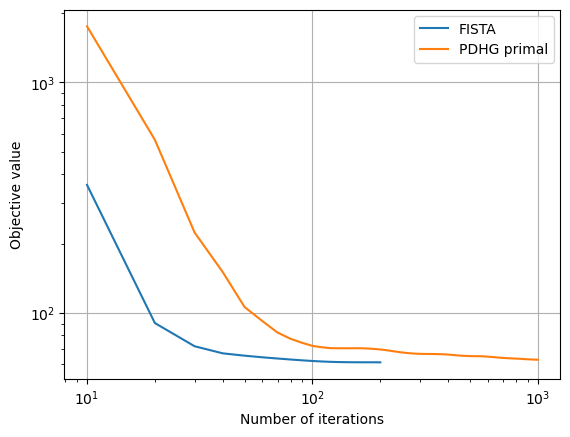

In [42]:
plt.figure()
plt.loglog(myFISTATV.iterations[1:], myFISTATV.objective[1:])
plt.loglog(myPDHG.iterations[1:], myPDHG.objective[1:])
plt.legend(['FISTA','PDHG primal'])
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')